In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Station = Base.classes.measurement
Measurement = Base.classes.measurement

for table_name in Base.classes.keys():
    print(table_name)

measurement
station


In [7]:
# Save references to each table
table_classes = {}
for table_name in Base.classes.keys():
    # Save class references to the dictionary
    table_classes[table_name] = Base.classes[table_name]

print(table_classes)

{'measurement': <class 'sqlalchemy.ext.automap.measurement'>, 'station': <class 'sqlalchemy.ext.automap.station'>}


In [8]:
# Create our session (link) from Python to the DB
Session = sessionmaker(bind=engine)
session = Session()
station_records = session.query(Base.classes.station).all()
for station in station_records:
    print(station)
session.close()

# Exploratory Precipitation Analysis

In [19]:
# Find the most recent date in the data set.
most_recent_date=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

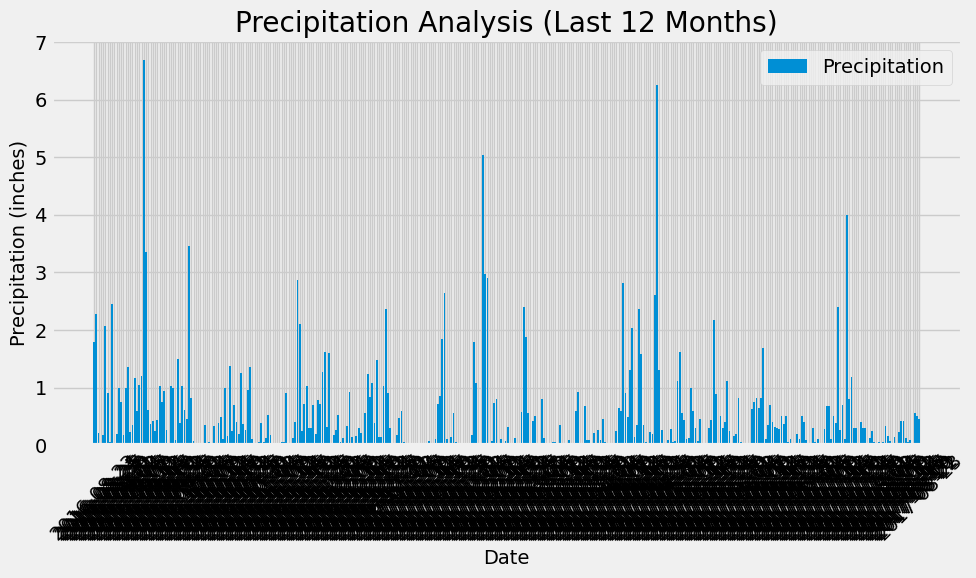

In [20]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = (dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365)).date()

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
precipitation_df.set_index('Date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df.index, precipitation_df['Precipitation'], label='Precipitation')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Analysis (Last 12 Months)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [21]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_stats = precipitation_df.describe()
print(precipitation_stats)

       Precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
print(f'Total number of stations: {station_count}')

Total number of stations: 19550


In [24]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print("Most active stations:")
for station, count in station_activity:
    print(f"Station ID: {station}, Observation Count: {count}")

Most active stations:
Station ID: USC00519281, Observation Count: 2772
Station ID: USC00519397, Observation Count: 2724
Station ID: USC00513117, Observation Count: 2709
Station ID: USC00519523, Observation Count: 2669
Station ID: USC00516128, Observation Count: 2612
Station ID: USC00514830, Observation Count: 2202
Station ID: USC00511918, Observation Count: 1979
Station ID: USC00517948, Observation Count: 1372
Station ID: USC00518838, Observation Count: 511


In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_activity[0][0] 

temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

# Print the results
lowest_temp, highest_temp, avg_temp = temperature_stats[0]
print(f"Most Active Station ID: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}°F")
print(f"Highest Temperature: {highest_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")





Most Active Station ID: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


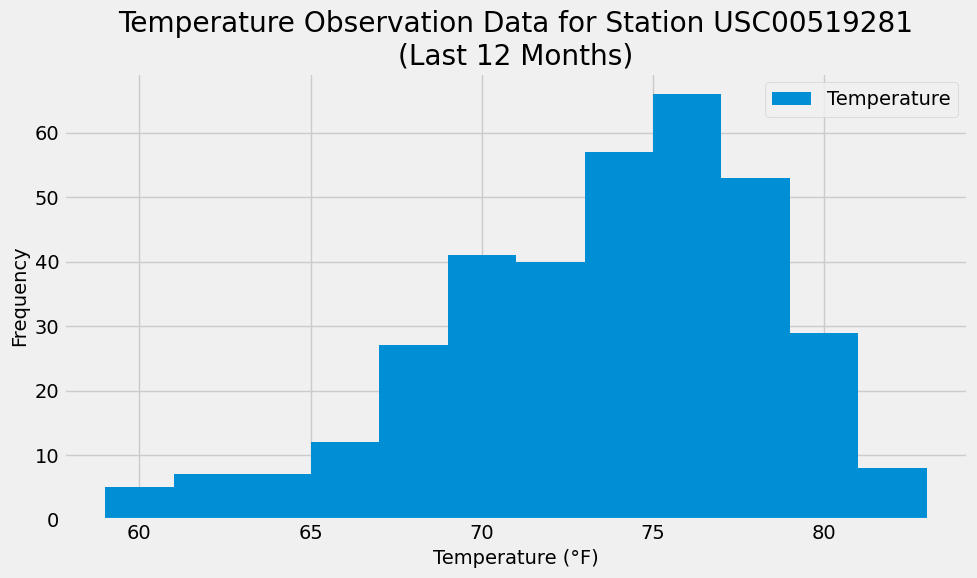

In [27]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station = station_activity[0][0]  

one_year_ago = (dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d') - dt.timedelta(days=365)).date()

temperature_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

temperature_df = pd.DataFrame(temperature_data, columns=['Temperature (°F)'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(temperature_df['Temperature (°F)'], bins=12, label='Temperature')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observation Data for Station {most_active_station}\n(Last 12 Months)')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [16]:
# Close Session
session.close()